In [28]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import umap
import seaborn as sns
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.covariance import MinCovDet, EmpiricalCovariance
import warnings
warnings.filterwarnings("ignore")

from src.util import calculate_difference_to_controls
from src.config import get_hussmann_supplementary_xlsx, get_experiment_artifacts, PAIRED_SAMPLES, SAMPLE
from src.models.outliers import outlier_detection, logratio_outlier_detection
from src.visualization.plots import screeplot, biplot, loadingsplot, FANCONI_ANEMIA_GENE_SET, HR_GENE_SET, NHEJ_GENE_SET, POLYMERASE_GENE_SET, pathway_pairplot

# PCA Visualisations

- Load sample data
- Get actual controls
- Calculate differential profiles
- Plot PCA pairwise components

In [30]:
# configurations for notebook

target_site_options = ["Adamson_T1", "T1", "T2", "T3"]
target_site = "Adamson_T1"
use_common_gene_set = True

In [31]:
if "Adamson" in target_site:
    Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
else:
    Z = pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
    Z
d = pd.concat(Z, axis=1)

if target_site == "T1":
    d = d[["T1"]].dropna()
    # d = d[["MB01", "MB02"]].dropna()

if target_site == "T2":
    d = d[["T2"]].dropna()
    # d = d[["MB03", "MB04"]].dropna()

if target_site == "T3":
    d = d[["T3"]].dropna()
    # d = d[["MB05", "MB06"]].dropna()

In [32]:
if use_common_gene_set and ("Adamson" not in target_site):
    Z_adamson = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
    d_adamson = pd.concat(Z_adamson, axis=1)
    adamson_genes = d_adamson.index.to_numpy()
    common_genes = np.intersect1d(d.index.to_numpy(), adamson_genes)
    d = d.loc[common_genes]


In [33]:
d.shape

(496, 7)

In [34]:
d.head()

Adamson_T1                             \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Actl6a                          0.182632                   0.367412   
Actr5                           0.188649                   0.370201   
Actr8                           0.197087                   0.374039   
Aicda                           0.189794                   0.366840   
Alkbh2                          0.191525                   0.363685   

                                                                  \
lumc_category Deletion 2bp microhomology Deletion with insertion   
Gene                                                               
Actl6a                          0.053167                0.157311   
Actr5                           0.043995                0.165087   
Actr8                           0.052188                0.159505   
Aicda                           0.059621                0.165860   
Alkbh2                          0.058760                0.163226   

                                                      \
lumc_category Homology Directed Repair Any Insertion   
Gene                                                   
Actl6a                        0.038832      0.169872   
Actr5                         0.048275      0.152818   
Actr8                         0.051384      0.137595   
Aicda                         0.050356      0.132990   
Alkbh2                        0.053326      0.133315   

                                           
lumc_category Deletion 3+bp microhomology  
Gene                                       
Actl6a                           0.030775  
Actr5                            0.030975  
Actr8                            0.028203  
Aicda                            0.034540  
Alkbh2                           0.036163

In [35]:
if "Adamson" in target_site:
    controls = d.index[d.index.str.contains("non-")].to_list()
else:
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(d, MinCovDet(random_state=0))
    results = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results = pd.Series(distances, index=d.index).sort_values(ascending=False)
    controls = results.iloc[-100:].index.to_series()

controls[-5:]

['non-targeting_032',
 'non-targeting_033',
 'non-targeting_034',
 'non-targeting_035',
 'non-targeting_036']

In [36]:
Xall = d.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")


In [37]:
adamson_data = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)
adamson_data.head()

,Gene,Plot Annotation,All Annotations,Gene.1,Plot Annotation.1,All Annotations.1
0,ACTL6A,Chromatin processes,"Chromatin remodeling, Histone acetylation, His...",APTX,Double-strand break repair,"Cellular response to DNA damage stimulus, DNA ..."
1,ACTR5,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ASCC3,DNA repair,"Cellular response to DNA damage stimulus, DNA ..."
2,ACTR8,Double-strand break repair,"Cellular response to DNA damage stimulus, Chro...",ATM,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
3,AICDA,Chromatin processes,"Demethylation, DNA metabolic process, Nucleic ...",ATR,Cell cycle checkpoint,"Cell cycle checkpoint, Cellular response to DN..."
4,ALKBH2,DNA repair,"Cellular response to DNA damage stimulus, Deme...",ATRIP,DNA repair,"Cell cycle checkpoint, Cellular response to DN..."


In [38]:
full_adamson_set = False

if full_adamson_set:
    annotations = "All Annotations"
    genes = "Gene"
else:
    annotations = "All Annotations.1"
    genes = "Gene.1"

pathway_binary_df = adamson_data[annotations].dropna().str.replace(", ", ",").str.get_dummies(sep=",")
pathway_binary_df[genes] = adamson_data[genes].dropna().str.capitalize()
pathway_binary_df = pathway_binary_df.set_index(genes)
pathway_binary_df.head()

,Base-excision repair,Cell cycle checkpoint,Cellular response to DNA damage stimulus,Chromatin remodeling,DNA conformation change,DNA damage checkpoint,DNA metabolic process,DNA repair,DNA replication,DNA replication initiation,...,Postreplication repair,Protein modification process,Protein ubiquitination,RNA biosynthetic process,Regulation of DNA replication,Regulation of transcription by RNA polymerase II,Response to radiation,Sister chromatid segregation,Unclassified,mRNA processing
Gene.1,,,,,,,,,,,,,,,,,,,,,
Aptx,0,0,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Ascc3,0,0,1,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Atm,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atr,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Atrip,0,1,1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
pathway_binary_df.shape

(118, 33)

In [40]:
pathway_binary_df.sum().sort_values()[::-1]

DNA metabolic process                                                 85
Cellular response to DNA damage stimulus                              76
DNA repair                                                            70
DNA replication                                                       37
Double-strand break repair                                            37
Cell cycle checkpoint                                                 18
Nuclear division                                                      18
DNA conformation change                                               18
DNA damage checkpoint                                                 16
Protein modification process                                          16
Nucleic acid phosphodiester bond hydrolysis                           13
Regulation of transcription by RNA polymerase II                      13
RNA biosynthetic process                                              12
Nucleotide-excision repair                         

In [41]:
common_genes = np.intersect1d(Xall.index.get_level_values(1), pathway_binary_df.index)

In [42]:
Xdiff = calculate_difference_to_controls(Xall, controls, d.columns.unique(0)).loc[common_genes]
Xdiff

(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)


Sample           Adamson_T1                             \
lumc_category Any Insertion Deletion 0bp microhomology   
Gene                                                     
Aptx               0.042496                  -0.010052   
Ascc3              0.025808                  -0.002433   
Atm               -0.006965                  -0.022595   
Atr               -0.007209                   0.019813   
Atrip              0.010881                   0.008123   
...                     ...                        ...   
Vps72              0.026648                  -0.003096   
Wapal              0.004675                  -0.015458   
Wrn                0.040411                  -0.021545   
Xrcc5              0.076162                  -0.018061   
Xrcc6              0.057952                  -0.015209   

Sample                                                               \
lumc_category Deletion 1bp microhomology Deletion 2bp microhomology   
Gene                                                                  
Aptx                           -0.023284                   0.001090   
Ascc3                           0.016000                   0.005006   
Atm                            -0.031863                   0.005585   
Atr                             0.099672                   0.007323   
Atrip                           0.052508                   0.013076   
...                                  ...                        ...   
Vps72                           0.024632                   0.011287   
Wapal                          -0.025279                  -0.002898   
Wrn                            -0.013308                  -0.004501   
Xrcc5                          -0.080665                  -0.009244   
Xrcc6                          -0.069847                  -0.009251   

Sample                                                             \
lumc_category Deletion 3+bp microhomology Deletion with insertion   
Gene                                                                
Aptx                            -0.000932               -0.008456   
Ascc3                            0.003586               -0.031238   
Atm                              0.010949                0.013203   
Atr                              0.003501               -0.080005   
Atrip                            0.012022               -0.060370   
...                                   ...                     ...   
Vps72                            0.010779               -0.041370   
Wapal                           -0.000377                0.025399   
Wrn                             -0.002948               -0.008711   
Xrcc5                            0.007676                0.011495   
Xrcc6                            0.007737                0.018689   

Sample                                  
lumc_category Homology Directed Repair  
Gene                                    
Aptx                         -0.000862  
Ascc3                        -0.016730  
Atm                           0.031685  
Atr                          -0.043095  
Atrip                        -0.036240  
...                                ...  
Vps72                        -0.028880  
Wapal                         0.013938  
Wrn                           0.010603  
Xrcc5                         0.012638  
Xrcc6                         0.009929  

[114 rows x 7 columns]

In [43]:
def get_labels(Xdiff, labels_to_plot):
    labels = pd.Series(np.repeat("", Xdiff.shape[0]), index=Xdiff.index)
    inter_labels = np.intersect1d(Xdiff.index, labels_to_plot)
    # labels[inter_labels] = inter_labels
    return pd.Series(inter_labels)

def f(x, y, **kwargs):
    z = kwargs["labels"]
    del kwargs["labels"]
    ax = sns.scatterplot(x,y, **kwargs)    

    if kwargs["label"] != "Other":
        for i in range(len(x)):
            ax.annotate(str(z.values[i]), xy=(x.values[i], y.values[i]), fontsize=8,
                        textcoords="offset points",
                    color=kwargs.get("color","k"),
                    bbox=dict(pad=0.0, alpha=0.0, color='black'),
                    va='center', ha='center')

(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)


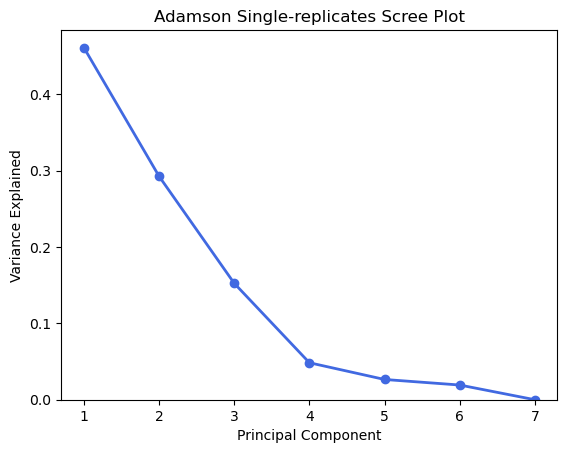

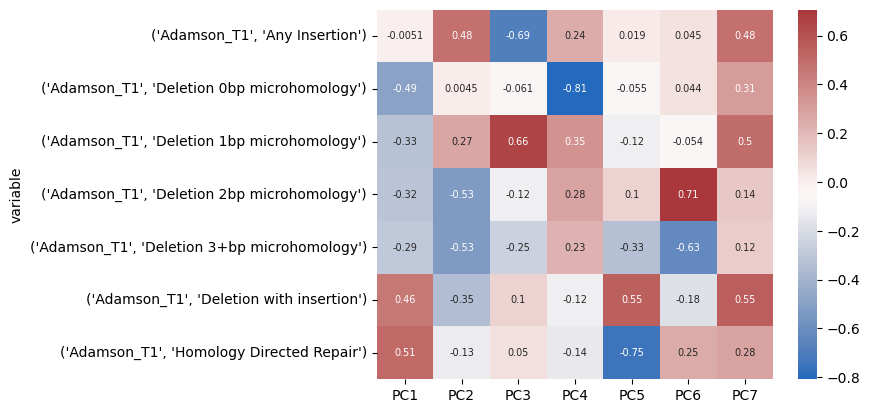

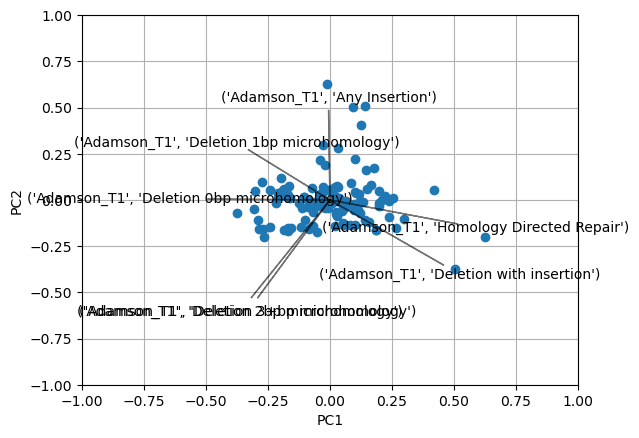

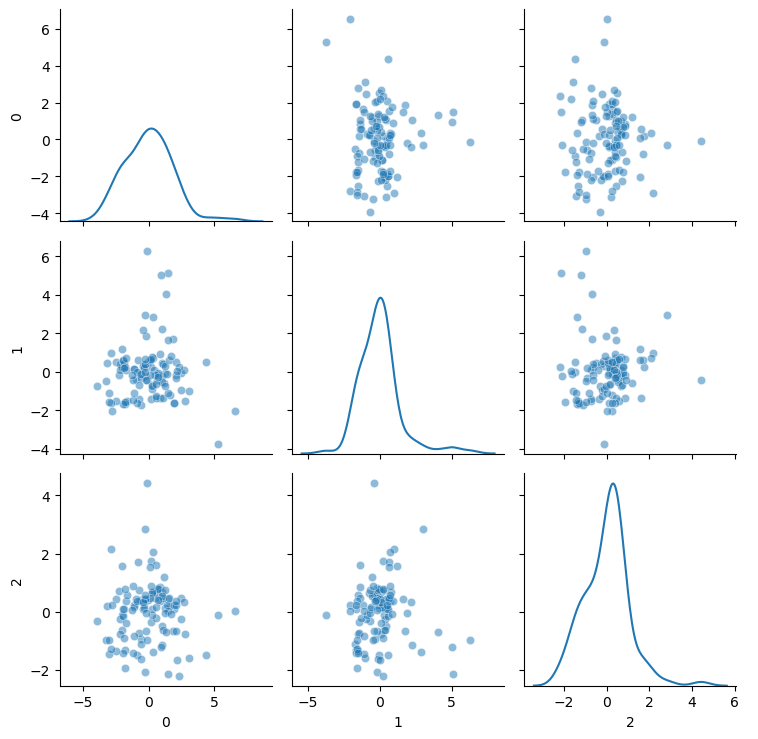

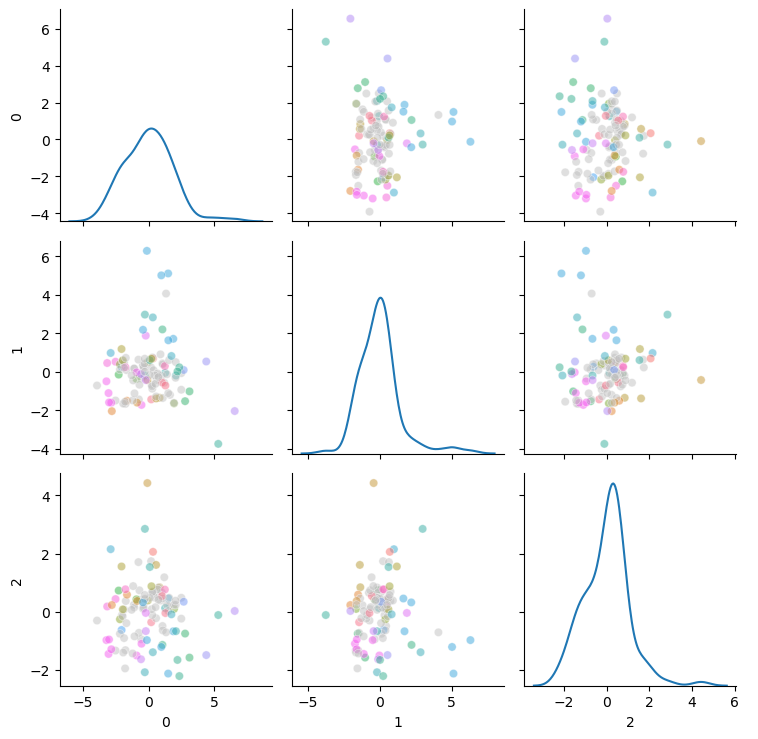

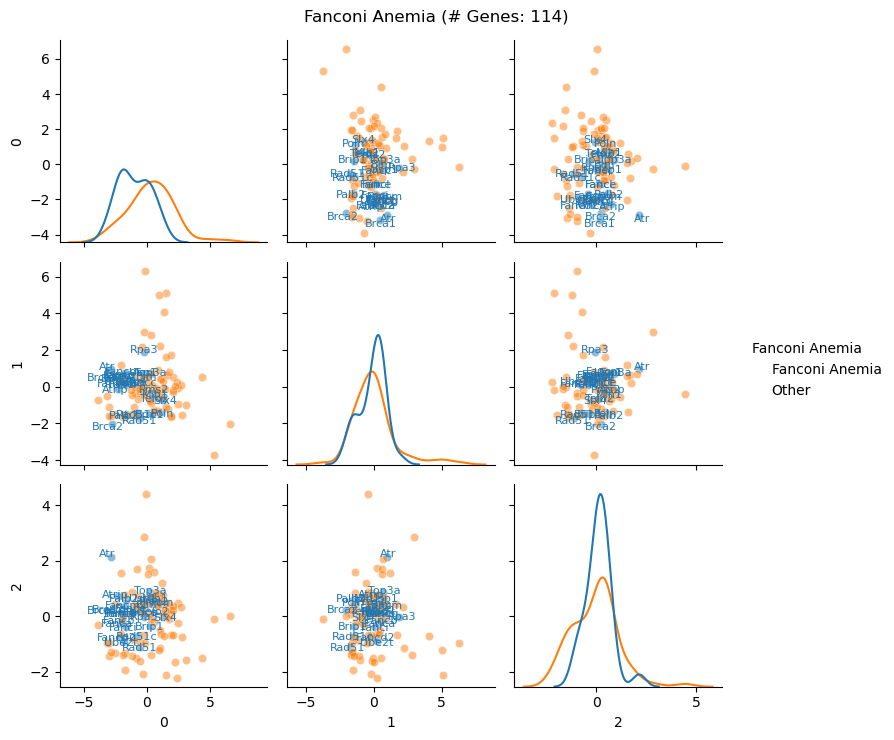

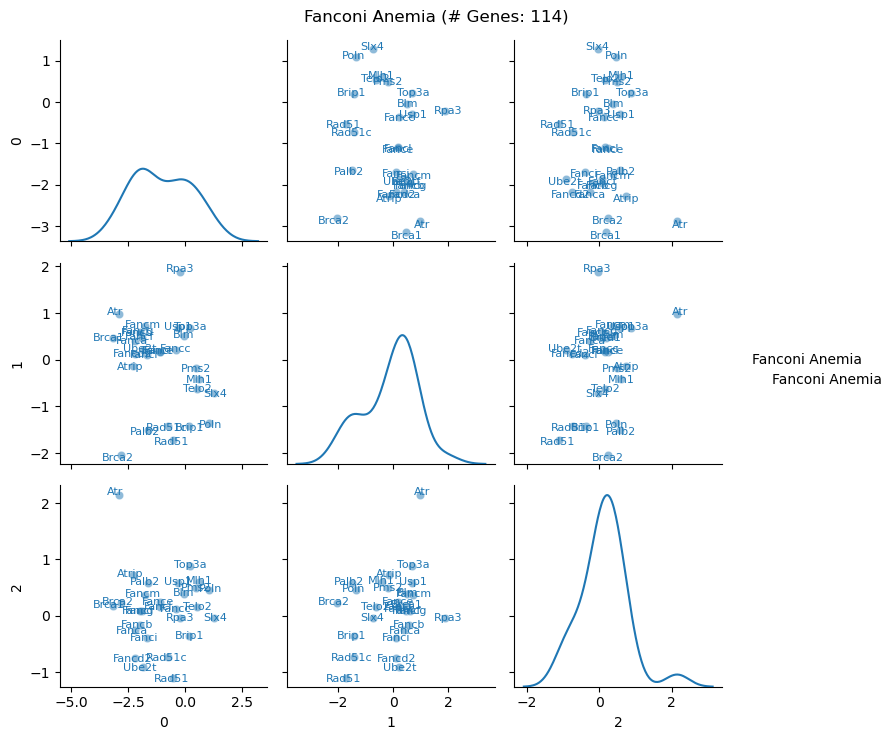

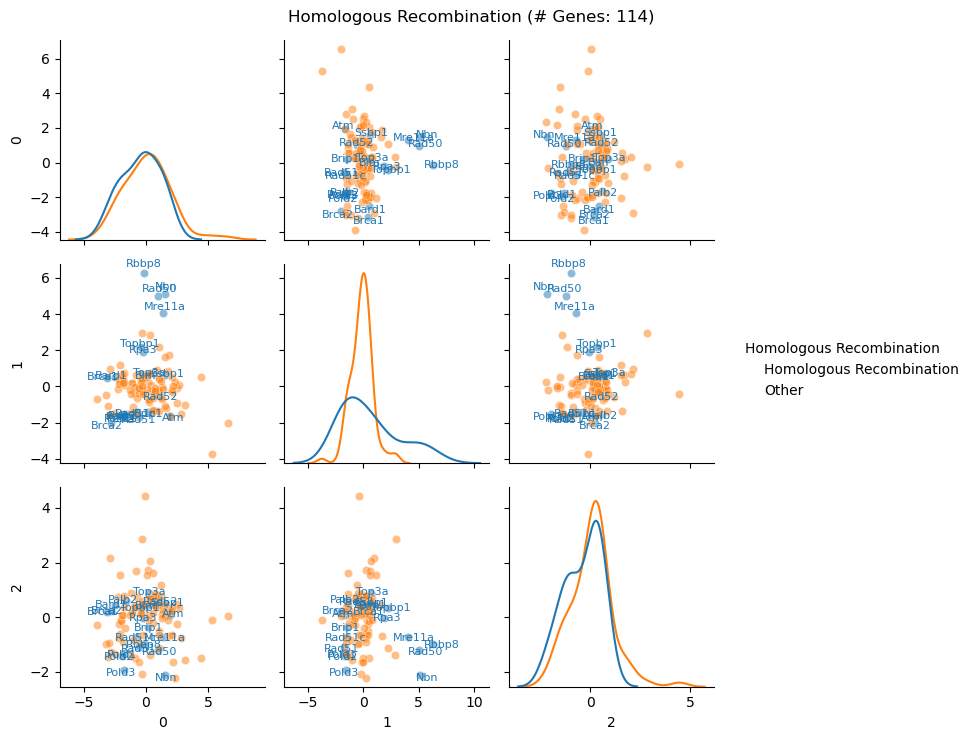

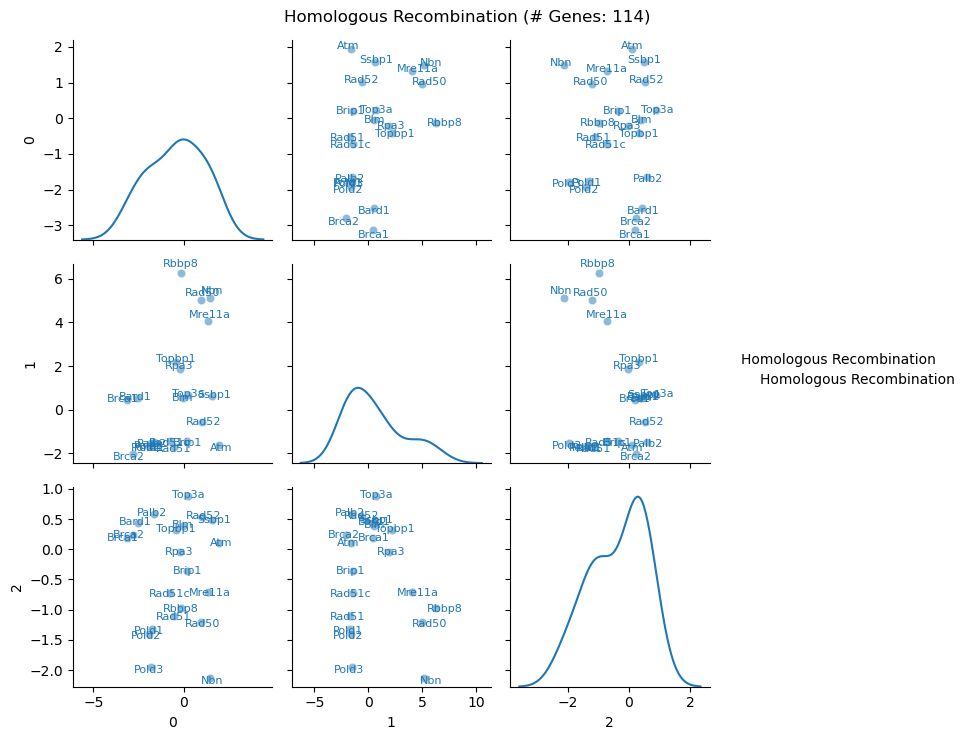

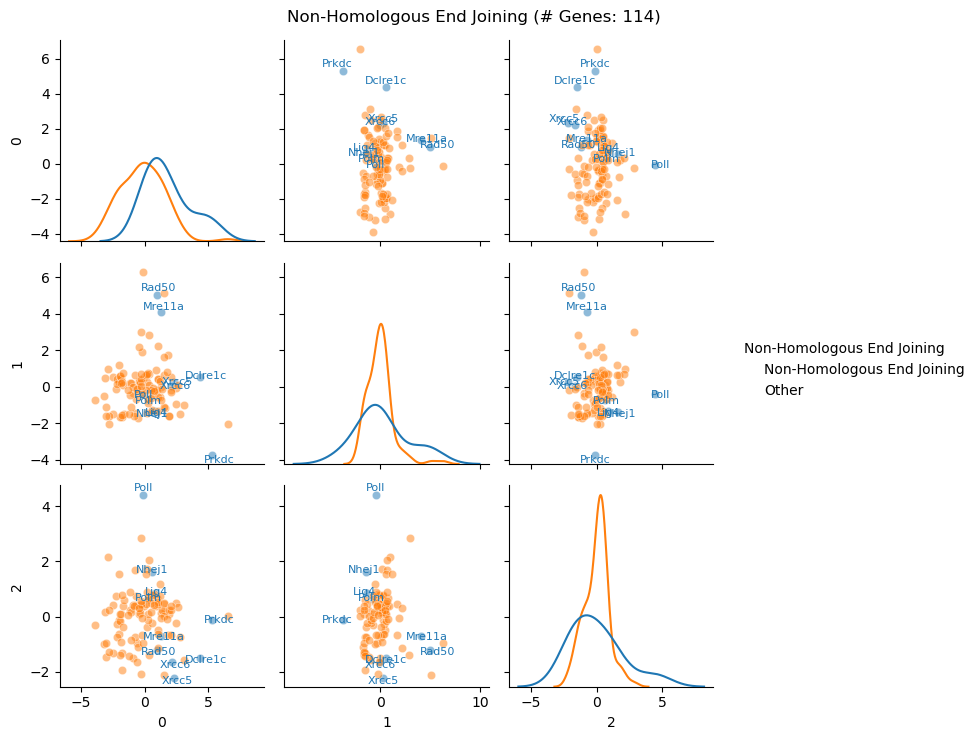

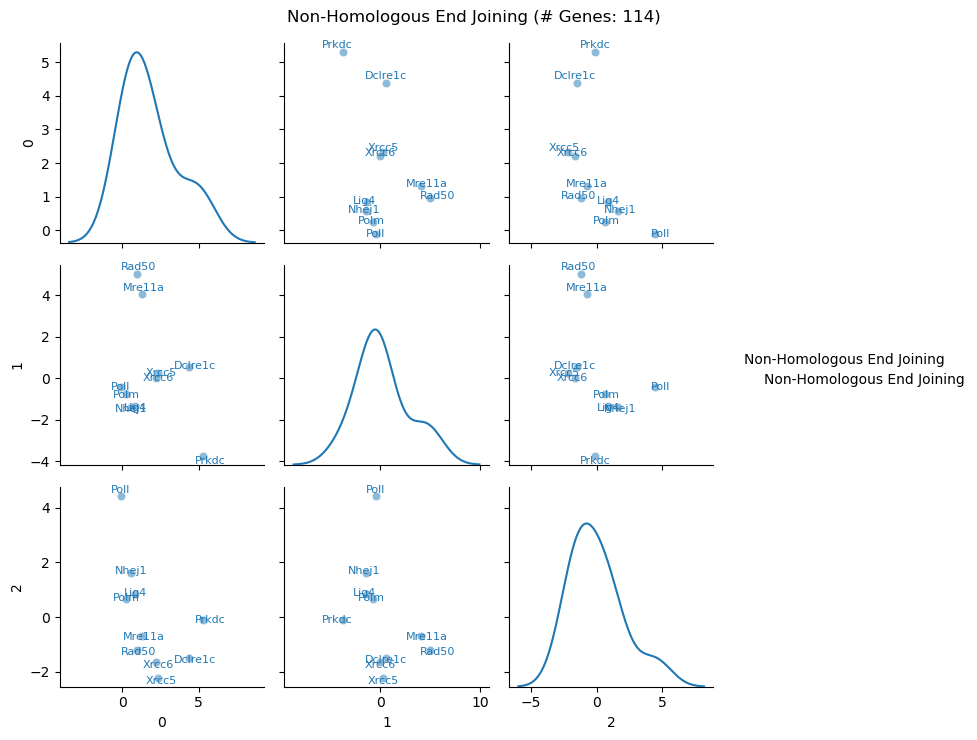

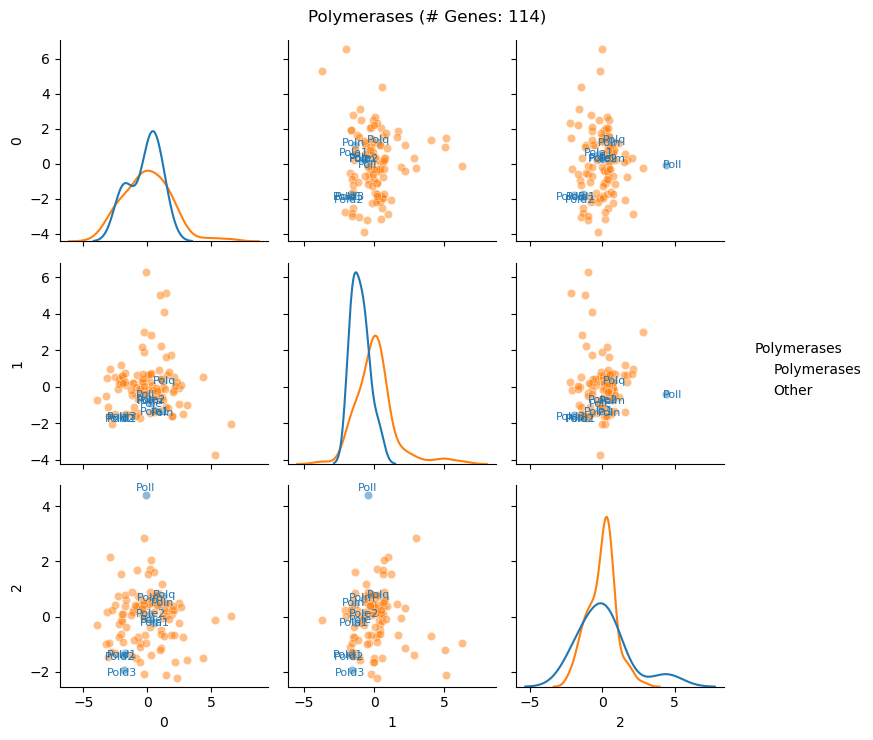

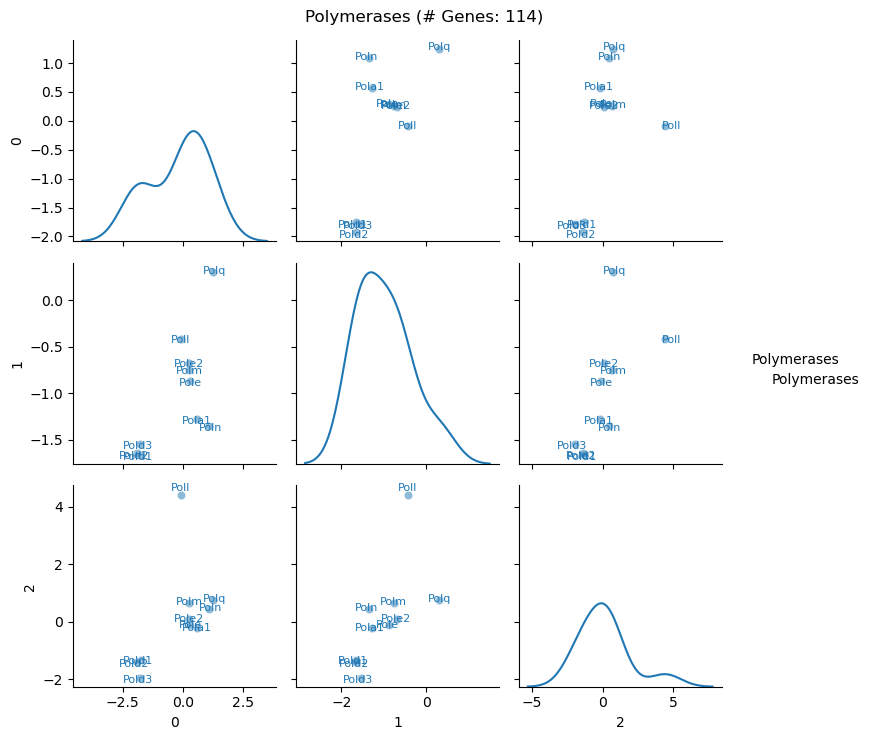

In [44]:
Xdiff = calculate_difference_to_controls(Xall, controls, d.columns.unique(0), return_log2_fold_change=False)
common_genes = np.intersect1d(Xdiff.index, pathway_binary_df.index)
X = Xdiff.loc[common_genes]

cluster_assignments_df = pkl.load(open("artifacts/adamson_cluster_assignments.pkl", "rb"))
cluster_assignments_df.head().iloc[0,:]["color"]
cluster_assignments_df["Gene"] = cluster_assignments_df.index.to_series().str.split("_", expand=True)[0].str.capitalize()
# cluster_assignments_df[["cluster_assignments_df"]].value_counts()
colors = cluster_assignments_df[["Gene", "color", "cluster_assignments"]].reset_index(drop=True).drop_duplicates().set_index("Gene").to_dict()["color"]
in_cluster_genes = cluster_assignments_df.loc[cluster_assignments_df["cluster_assignments"] != -1]["Gene"].unique()

for i in X.index.to_list():
    if i not in colors:
        colors[i] = (0.7529411764705882, 0.7529411764705882, 0.7529411764705882)

pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(X, EmpiricalCovariance())
fig, ax = plt.subplots()
screeplot(explained_variance_ratio, ax, "Adamson Single-replicates")
plt.show()

loadings_df, z = loadingsplot(loadings, X.columns.to_list())
plt.show()

# Call the function. Use only the 2 PCs.
pcs_to_analyse = [0, 1]
biplot(pca_scores[:,pcs_to_analyse], 
    loadings_df.iloc[:,pcs_to_analyse].values, 
    labels=loadings_df.index, 
    components=loadings_df.iloc[:,pcs_to_analyse].columns)
plt.show()


pp_df = pd.DataFrame(pca_scores, index=X.index).iloc[:,:3]
pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}.pdf".format(target_site))
plt.savefig("artifacts/pca_{}.png".format(target_site))
plt.show()

pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False, 
                 hue=pp_df.index.to_list(), palette=colors)
plt.savefig("artifacts/pca_colored{}.pdf".format(target_site))
plt.savefig("artifacts/pca_colored{}.png".format(target_site))
plt.show()

pathway_name = "Fanconi Anemia"
pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Homologous Recombination"
pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Non-Homologous End Joining"
pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Polymerases"
pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

(496, 7)
(29, 7)
(496, 7)
(7,)


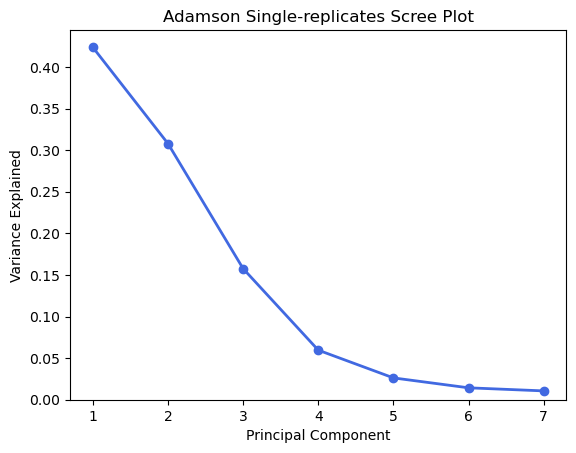

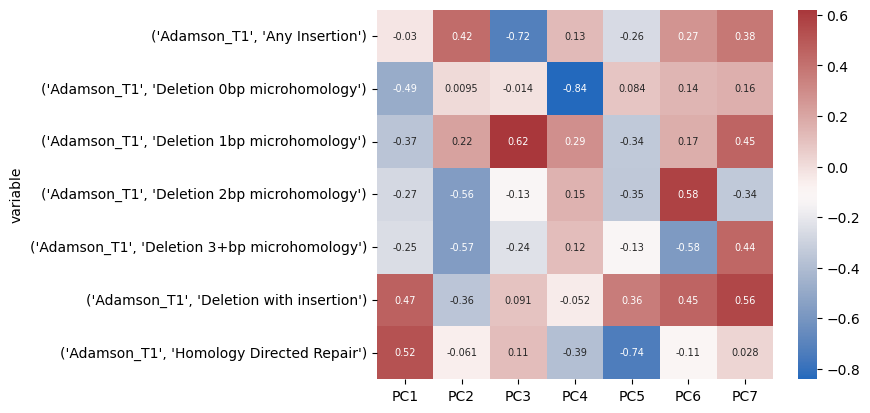

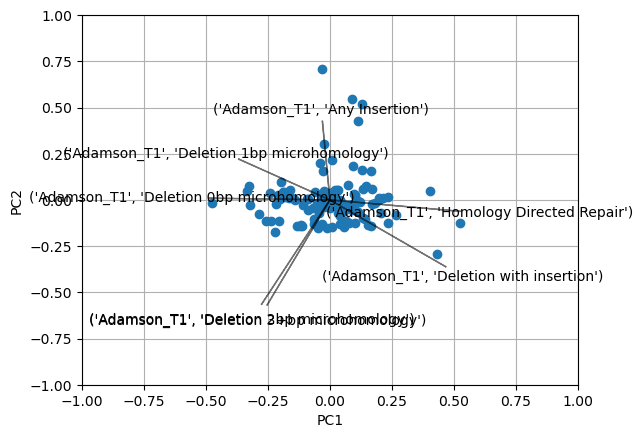

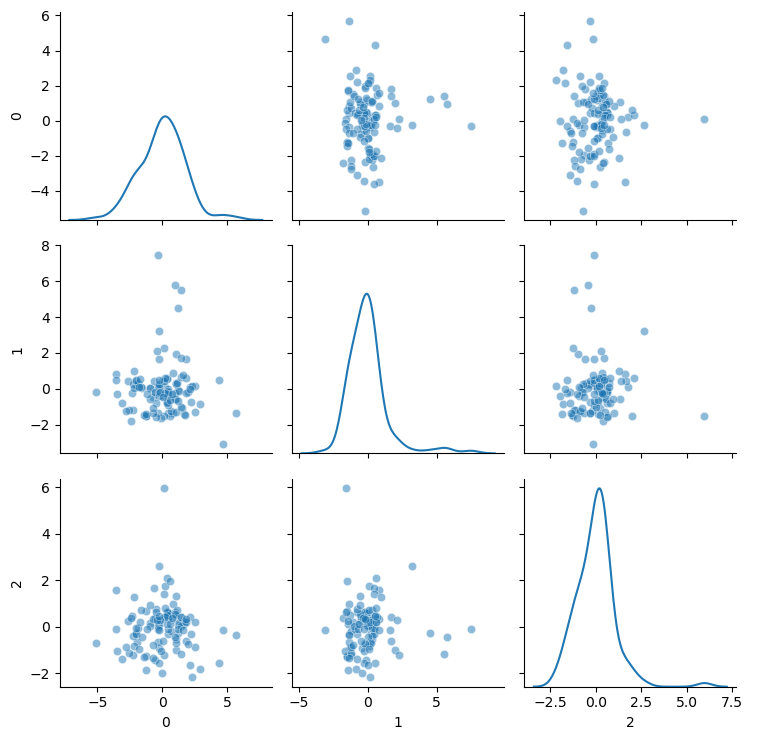

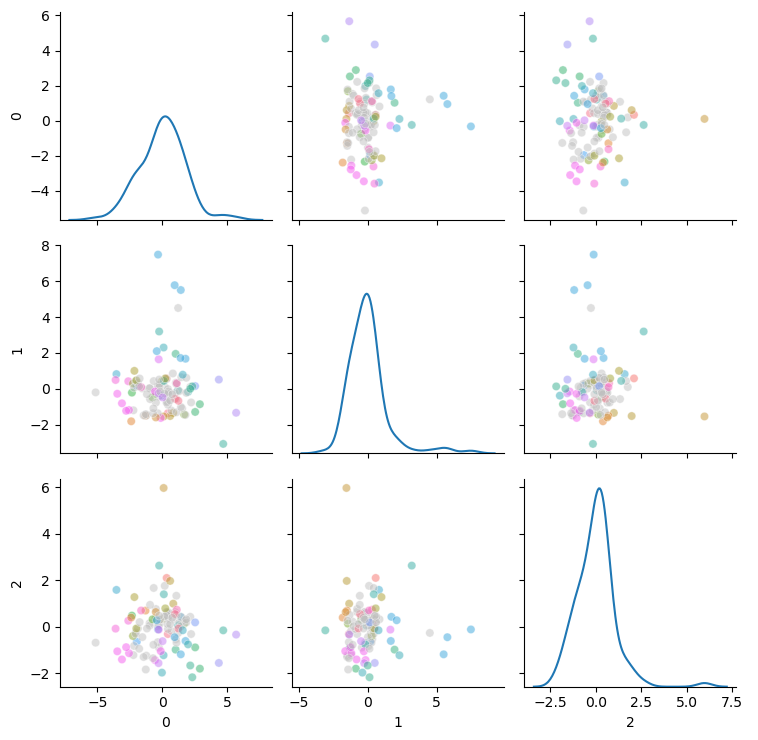

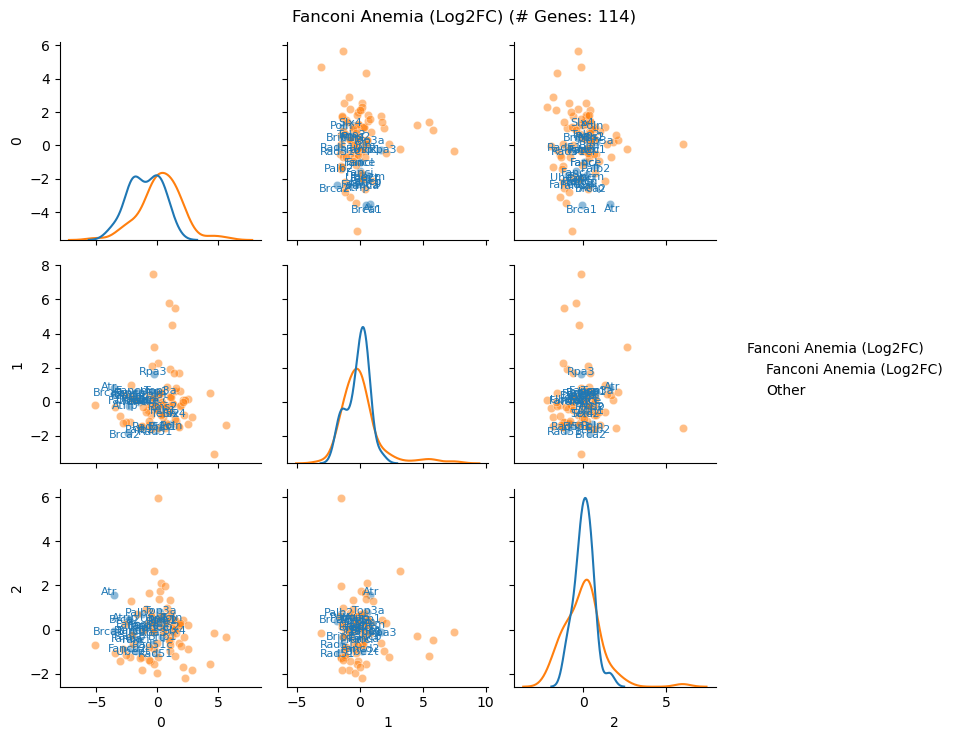

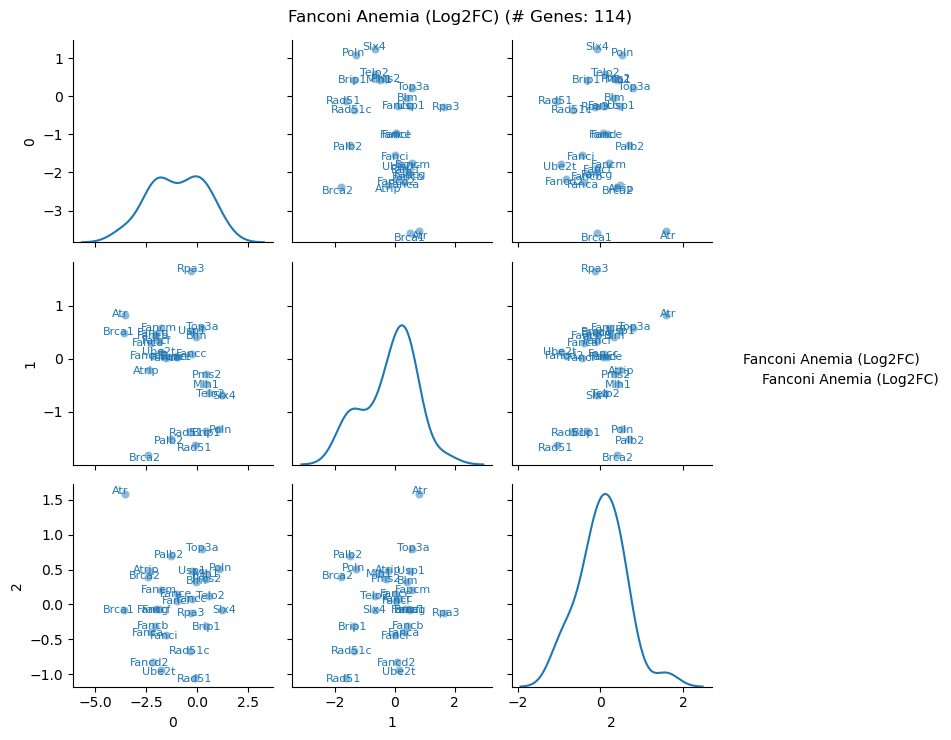

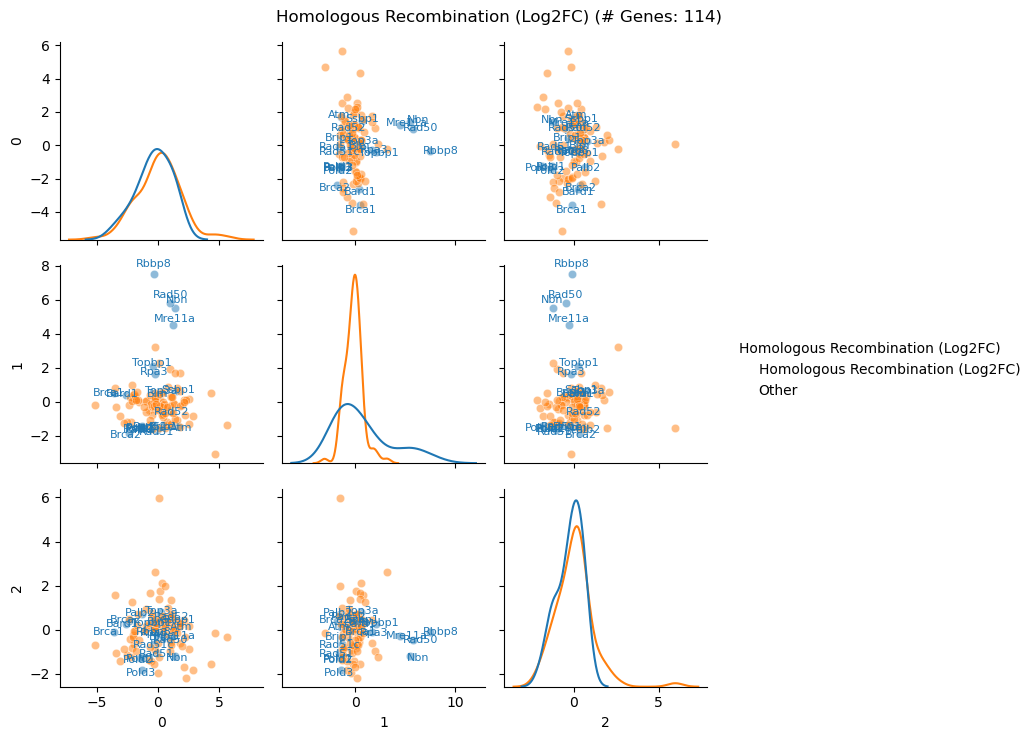

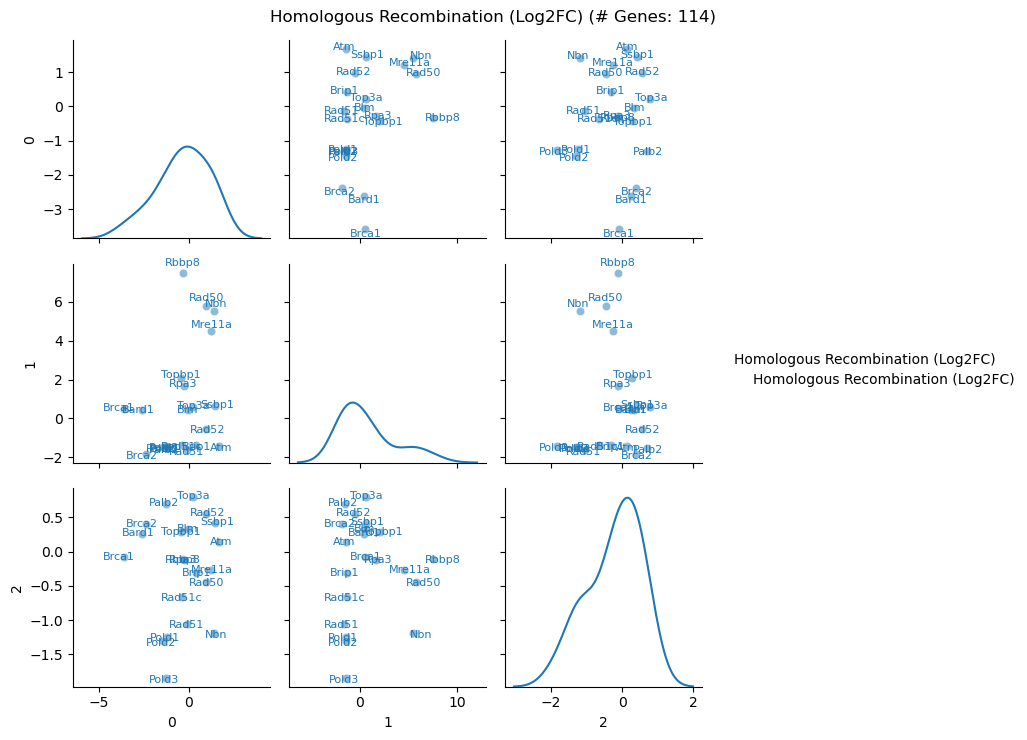

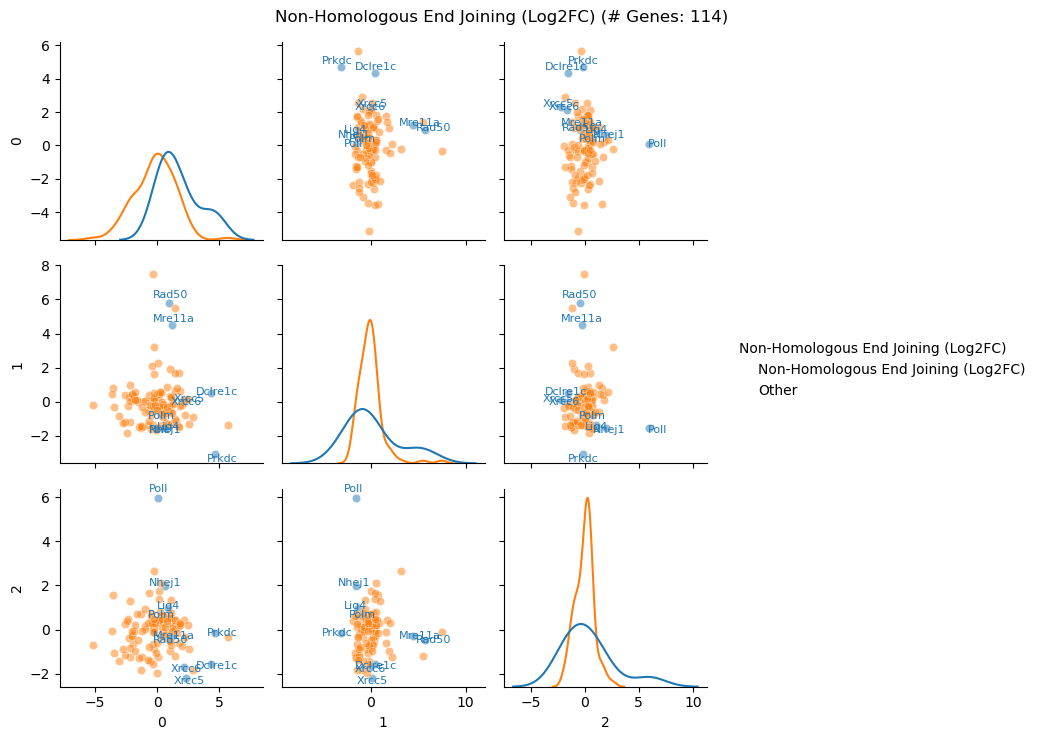

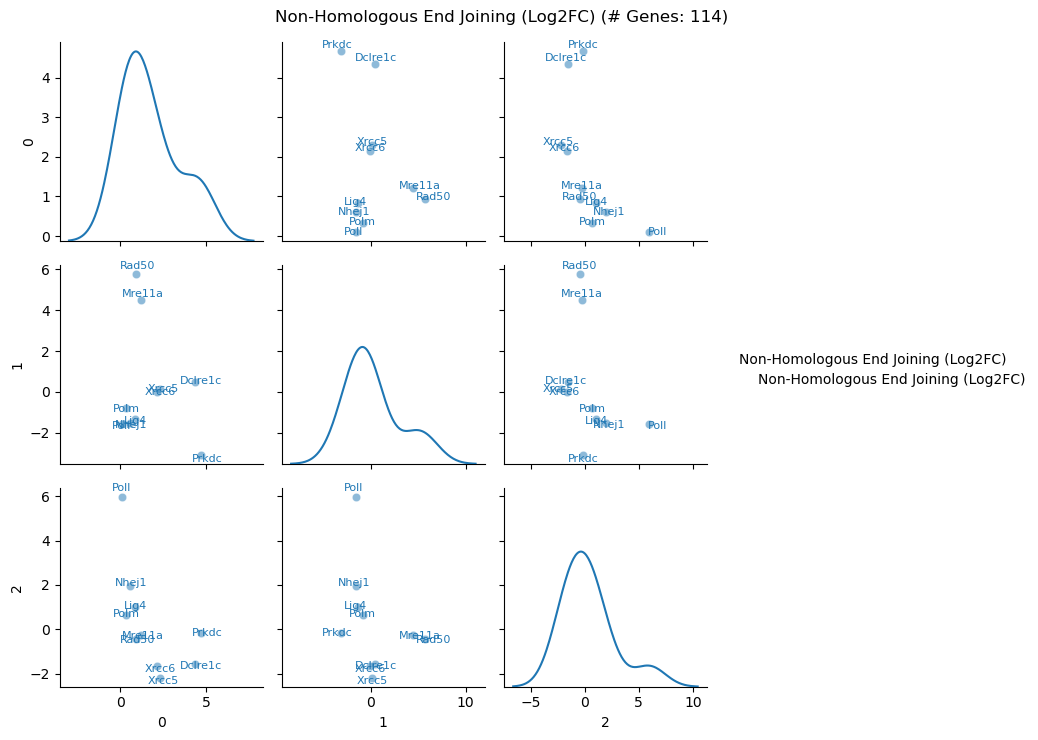

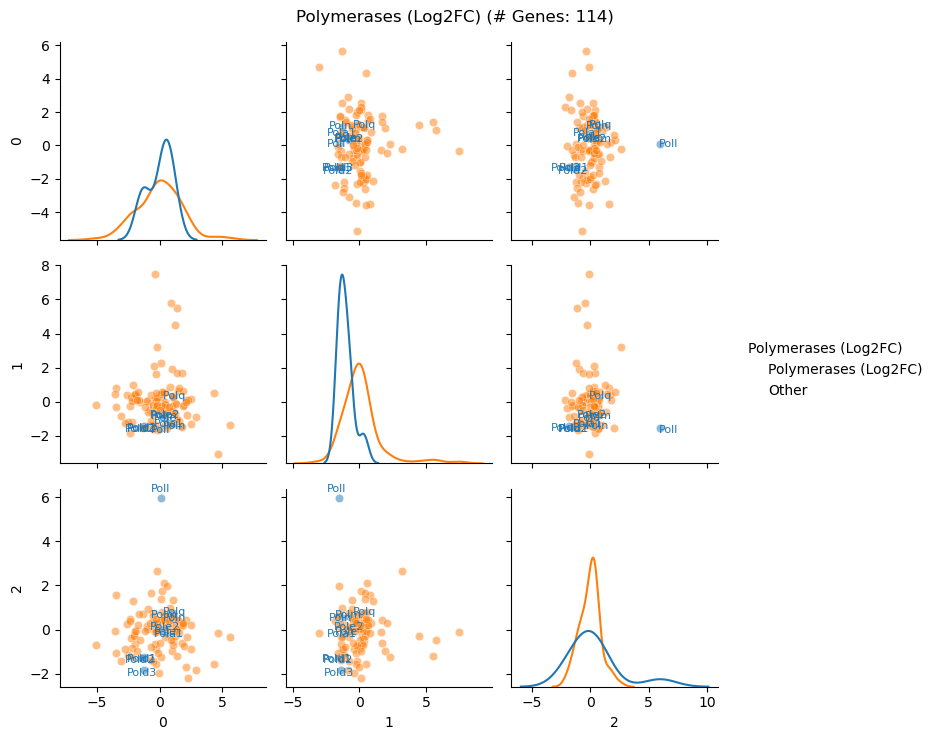

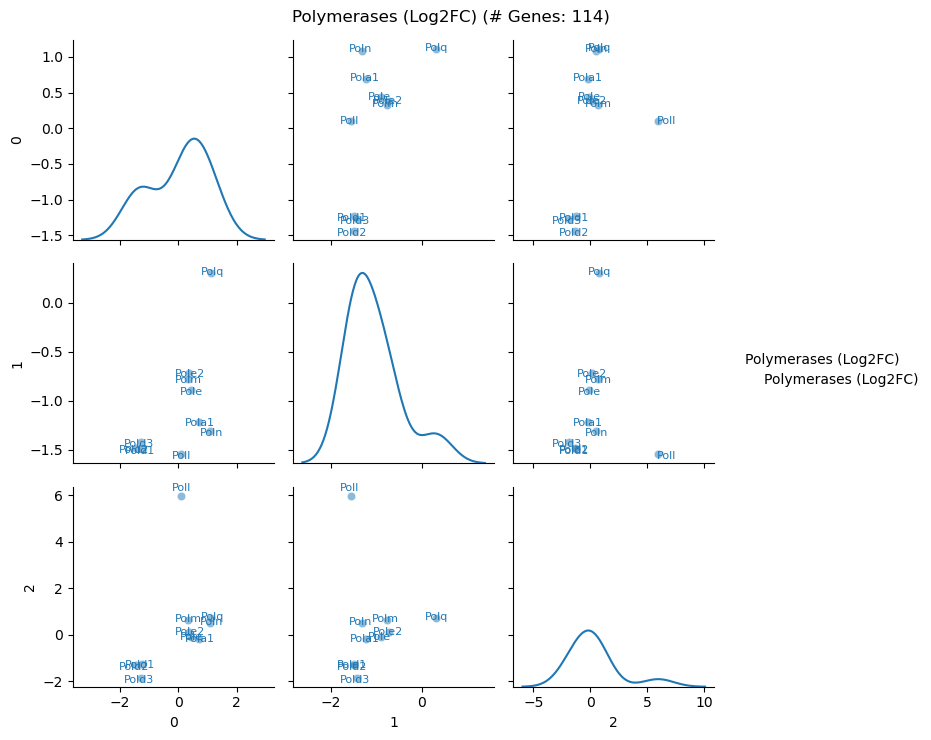

In [45]:
Xdiff = calculate_difference_to_controls(Xall, controls, d.columns.unique(0), return_log2_fold_change=True)
common_genes = np.intersect1d(Xdiff.index, pathway_binary_df.index)
X = Xdiff.loc[common_genes]

pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(X, EmpiricalCovariance())
fig, ax = plt.subplots()
screeplot(explained_variance_ratio, ax, "Adamson Single-replicates")
plt.show()

loadings_df, z = loadingsplot(loadings, X.columns.to_list())
plt.show()

# Call the function. Use only the 2 PCs.
pcs_to_analyse = [0, 1]
biplot(pca_scores[:,pcs_to_analyse], 
    loadings_df.iloc[:,pcs_to_analyse].values, 
    labels=loadings_df.index, 
    components=loadings_df.iloc[:,pcs_to_analyse].columns)
plt.show()


pp_df = pd.DataFrame(pca_scores, index=X.index).iloc[:,:3]
pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_Log2FC_{}.pdf".format(target_site))
plt.savefig("artifacts/pca_Log2FC_{}.png".format(target_site))
plt.show()

pathway_pairplot(pp_df, None, None, show_only_pathway_genes=False, 
                 hue=pp_df.index.to_list(), palette=colors)
plt.savefig("artifacts/pca_Log2FC_colored{}.pdf".format(target_site))
plt.savefig("artifacts/pca_Log2FC_colored{}.png".format(target_site))
plt.show()

pathway_name = "Fanconi Anemia (Log2FC)"
pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, FANCONI_ANEMIA_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Homologous Recombination (Log2FC)"
pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, HR_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Non-Homologous End Joining (Log2FC)"
pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, NHEJ_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

pathway_name = "Polymerases (Log2FC)"
pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=False)
plt.savefig("artifacts/pca_{}_and_others{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}_and_others{}.png".format(pathway_name, target_site))
plt.show()

pathway_pairplot(pp_df, pathway_name, POLYMERASE_GENE_SET, show_only_pathway_genes=True)
plt.savefig("artifacts/pca_{}{}.pdf".format(pathway_name, target_site))
plt.savefig("artifacts/pca_{}{}.png".format(pathway_name, target_site))
plt.show()

# Psuedo-controls
- Use psuedo-controls and compare UMAPs to above plots

# Data Integration

- Load T2 and T3 target data
- Get difference profiles based on psuedo-controls
- Combine and visualise above plots again

In [46]:
Z = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
Z.update(pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb")))
del Z["T1"]
# del Z["T2"]
# del Z["T3"]
d_paired = pd.concat(Z, axis=1).dropna()
print(d_paired.shape)

(415, 21)


In [47]:
Xall = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall.head()

lumc_category      Any Insertion  Deletion 0bp microhomology  \
Sample     Gene                                                
Adamson_T1 Actl6a       0.169872                    0.182632   
           Actr5        0.152818                    0.188649   
           Actr8        0.137595                    0.197087   
           Aicda        0.132990                    0.189794   
           Alkbh2       0.133315                    0.191525   

lumc_category      Deletion 1bp microhomology  Deletion 2bp microhomology  \
Sample     Gene                                                             
Adamson_T1 Actl6a                    0.367412                    0.053167   
           Actr5                     0.370201                    0.043995   
           Actr8                     0.374039                    0.052188   
           Aicda                     0.366840                    0.059621   
           Alkbh2                    0.363685                    0.058760   

lumc_category      Deletion 3+bp microhomology  Deletion with insertion  \
Sample     Gene                                                           
Adamson_T1 Actl6a                     0.030775                 0.157311   
           Actr5                      0.030975                 0.165087   
           Actr8                      0.028203                 0.159505   
           Aicda                      0.034540                 0.165860   
           Alkbh2                     0.036163                 0.163226   

lumc_category      Homology Directed Repair  
Sample     Gene                              
Adamson_T1 Actl6a                  0.038832  
           Actr5                   0.048275  
           Actr8                   0.051384  
           Aicda                   0.050356  
           Alkbh2                  0.053326

In [48]:
common_genes = Xall.index.get_level_values(1).to_series()

In [49]:
results = {}
pseudo_controls = {}
for alias in Z.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z[alias].loc[common_genes], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z[alias].loc[common_genes].index).sort_values(ascending=False)
    pseudo_controls[alias] = results[alias].iloc[-len(controls):].index.to_series()

In [50]:
Xpseudodiff = {}
for alias in Z.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall.loc[Xall.index.get_level_values(0) == alias, :],\
                            pseudo_controls[alias], [alias])

(415, 7)
(10, 7)
(415, 7)
(7,)
(415, 7)
(415, 7)
(10, 7)
(415, 7)
(7,)
(415, 7)
(415, 7)
(10, 7)
(415, 7)
(7,)
(415, 7)


In [51]:
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)

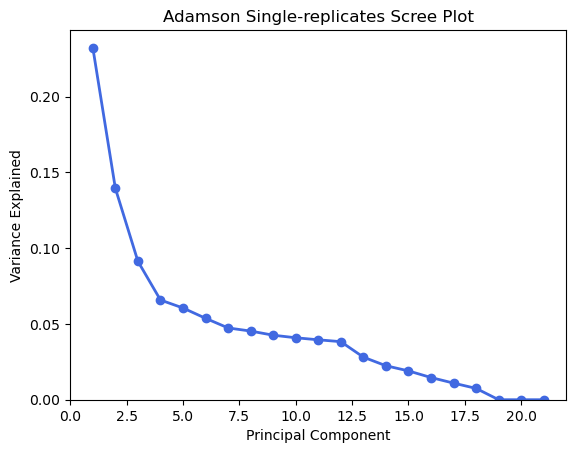

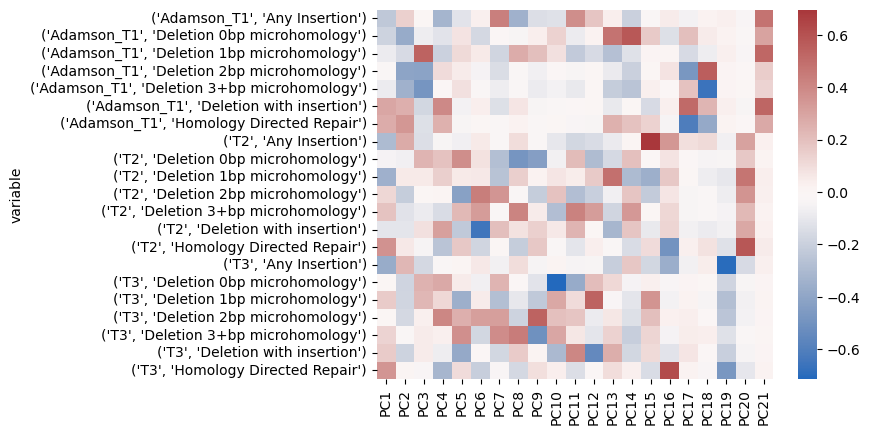

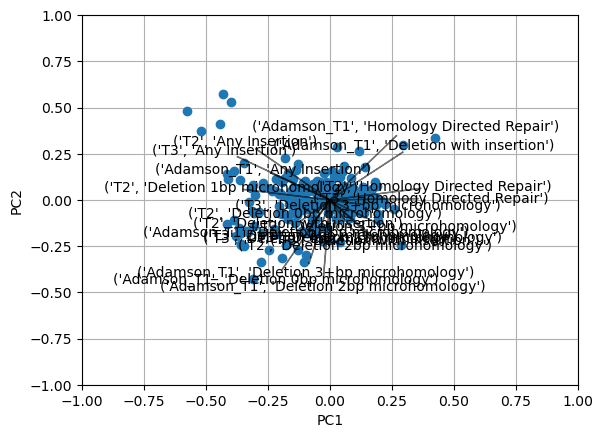

In [52]:
pca_scores, loadings, explained_variance_ratio, distances, pvalues = outlier_detection(Xpseudodiff, EmpiricalCovariance())
fig, ax = plt.subplots()
screeplot(explained_variance_ratio, ax, "Adamson Single-replicates")
plt.show()

loadings_df, z = loadingsplot(loadings, Xpseudodiff.columns.to_list())
plt.show()

# Call the function. Use only the 2 PCs.
pcs_to_analyse = [0, 1]
biplot(pca_scores[:,pcs_to_analyse], 
    loadings_df.iloc[:,pcs_to_analyse].values, 
    labels=loadings_df.index, 
    components=loadings_df.iloc[:,pcs_to_analyse].columns)
plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

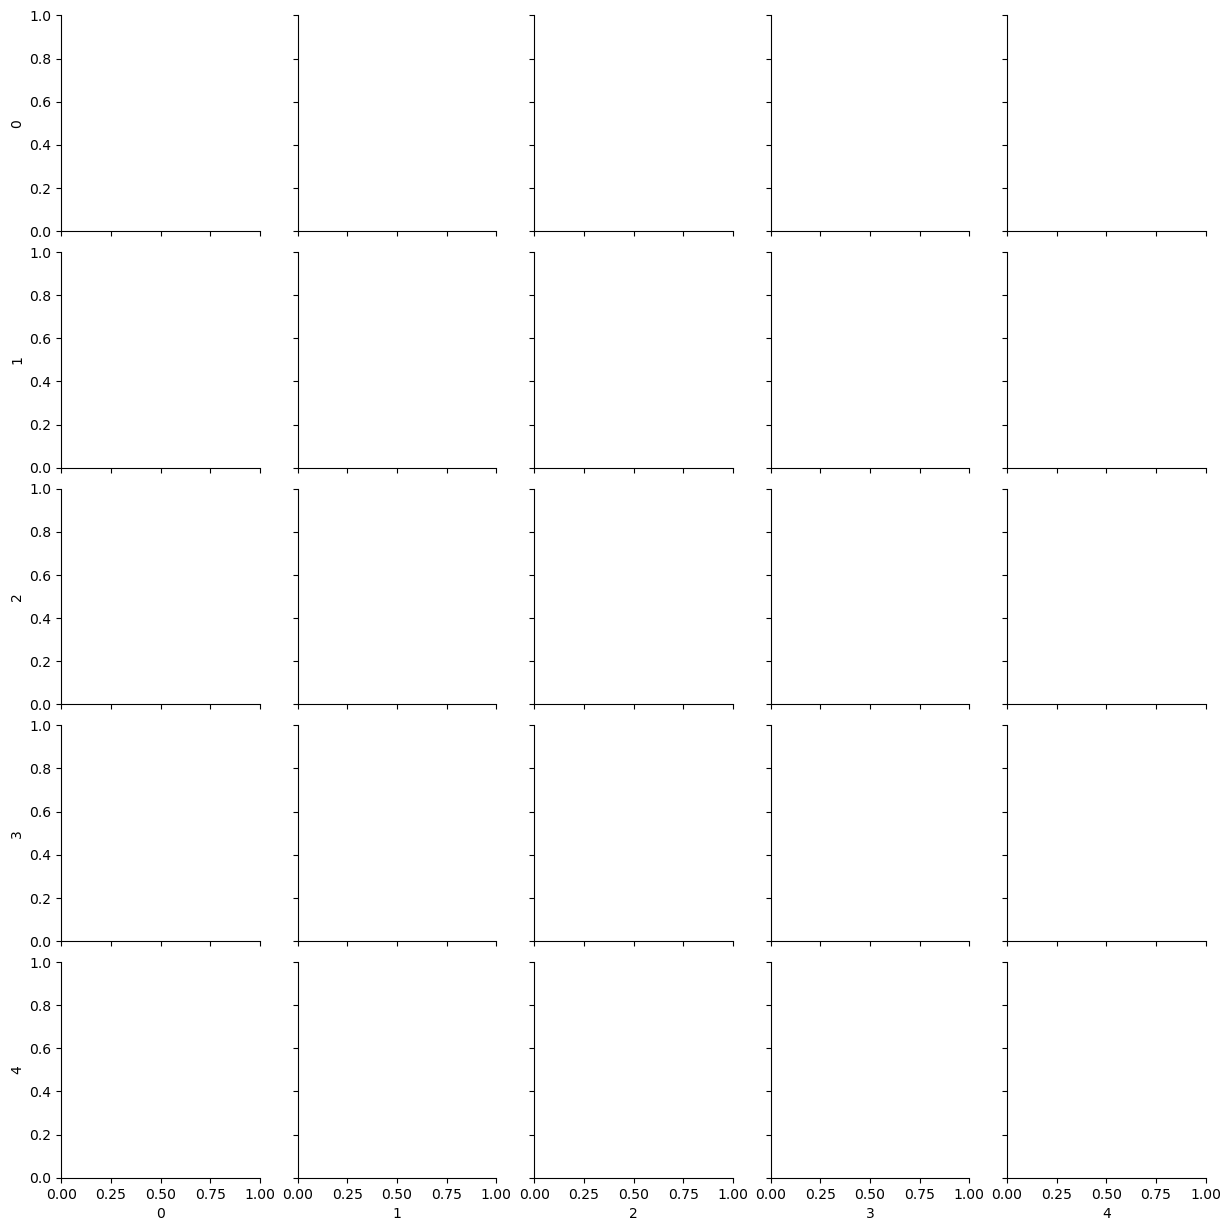

In [53]:
pathway_name = "Fanconi Anemia"
pp_df = pd.DataFrame(pca_scores, index=Xpseudodiff.index).iloc[:,:5]
pp_df["Fanconi Anemia"] = Xdiff.index.to_series().isin(FANCONI_ANEMIA_GENE_SET).apply(lambda x: pathway_name if x else "Other")
g = sns.PairGrid(data=pp_df, hue=pathway_name, hue_order=[pathway_name, "Other"])
g.map_offdiag(f, labels=get_labels(pp_df, FANCONI_ANEMIA_GENE_SET), alpha=0.5)
g.map_diag(sns.kdeplot, common_norm=False)
g.add_legend()
g.fig.suptitle(pathway_name, y=1.01)
plt.savefig("artifacts/pca_{}_and_others.integrated.pdf".format(pathway_name))
plt.show()

In [ ]:
pp_df = pd.DataFrame(pca_scores, index=Xpseudodiff.index).iloc[:,:3]
pp_df["Fanconi Anemia"] = Xpseudodiff.index.to_series().isin(FANCONI_ANEMIA_GENE_SET).apply(lambda x: pathway_name if x else "Other")
g = sns.PairGrid(data=pp_df.loc[pp_df[pathway_name] == pathway_name], hue=pathway_name, hue_order=[pathway_name], height=4)
g.map_offdiag(f, labels=get_labels(pp_df, FANCONI_ANEMIA_GENE_SET), alpha=0.5)
g.map_diag(sns.kdeplot, common_norm=False)
g.add_legend()
g.fig.suptitle(pathway_name, y=1.01)
plt.savefig("artifacts/pca_{}.integrated.pdf".format(pathway_name))
plt.show()